# Training YOLO

In [1]:
import kagglehub
import os

from matplotlib.axes import Axes
import matplotlib.pyplot as plt
import numpy as np
import cv2
import yaml
import pandas as pd
import shutil
import random
from datetime import datetime
from ultralytics import YOLO

/Users/jcarmona/Repos/in-progress/KSchool-TFM/ks-tfm.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
a = YOLO("yolov8n.pt")
a.model_name

##### Descarga

In [55]:
data_path = os.path.abspath("./data")

dl_path = None
if not os.path.exists(data_path):
    url = "pkdarabi/bone-fracture-detection-computer-vision-project"
    dl_path = kagglehub.dataset_download(url)
    print(f"Data downloaded at {dl_path}")
else:
    print(f"Data is at {data_path}")
    
if dl_path:
    shutil.move(dl_path, data_path)
    print(f"Data moved to {data_path}")
    
dl_path = data_path

Data is at /Users/jcarmona/Repos/in-progress/KSchool-TFM/data


### Preprocesado para YOLO

In [56]:
data_path = os.path.join(dl_path, "BoneFractureYolo8")

with open(os.path.join(data_path, "data.yaml"), "r") as f:
    data = yaml.safe_load(f)
    
data_yaml = {"path": data_path, **data}
data_yaml["train"] = "train/images"
data_yaml["val"] = "valid/images"
data_yaml["test"] = "test/images"

with open(os.path.join(data_path, "data.yaml"), "w") as f:
    yaml.safe_dump(data_yaml, f)
    
data_yaml

{'path': '/Users/jcarmona/Repos/in-progress/KSchool-TFM/data/BoneFractureYolo8',
 'names': ['elbow positive',
  'fingers positive',
  'forearm fracture',
  'humerus fracture',
  'humerus',
  'shoulder fracture',
  'wrist positive'],
 'nc': 7,
 'roboflow': {'license': 'CC BY 4.0',
  'project': 'bone-fracture-detection-daoon',
  'url': 'https://universe.roboflow.com/veda/bone-fracture-detection-daoon/dataset/4',
  'version': 4,
  'workspace': 'veda'},
 'test': 'test/images',
 'train': 'train/images',
 'val': 'valid/images'}

In [57]:
def preprocess_labels(labels: list[str]) -> list:
    new_labels = []
    for l in labels:
        label = l.split(" ")
        class_idx = int(label[0])
        xs = [float(label[i]) for i in range(1, len(label), 2)]
        ys = [float(label[i]) for i in range(2, len(label), 2)]
        x_min, y_min, x_max, y_max = min(xs), min(ys), max(xs), max(ys)
        width, height = x_max - x_min, y_max - y_min
        x_center, y_center = x_min + width / 2, y_min + height / 2
        new_labels.append(f"{class_idx} {x_center} {y_center} {width} {height}")
        
    return new_labels
        
def preprocess() -> bool:
    try:
        for s in ["train", "valid", "test"]:
            labels_path = os.path.join(data_path, s, "labels")
            if not os.path.exists(labels_path+".old"):
                os.rename(labels_path, labels_path+".old")
                os.makedirs(labels_path, exist_ok=True)
                
            for filename in os.listdir(labels_path+".old"):
                with open(fp := os.path.join(labels_path+".old", filename), "r") as f:
                    labels = f.readlines()
                
                if filename == "image1_111_png.rf.3893d8f7588cea4d796d26119e52637f.txt":
                    pass
                labels = preprocess_labels(labels)
                
                with open(os.path.join(labels_path, filename), "w") as f:
                    f.write("\n".join(labels))
        return True
    except:
        return False
       
preprocessed = preprocess()         
print(f"Labels prprocessed!" if preprocessed else "Labels not preprocessed")

Labels prprocessed!


##### Visualización

In [58]:
with open(os.path.join(data_path, "data.yaml"), "r") as f:
    data_yaml = yaml.safe_load(f)
    
class_names = {i: name for i, name in enumerate(data_yaml["names"])}

In [ ]:
def read_label(subset: str, name: str) -> pd.DataFrame:
    with open(os.path.join(data_path, subset, "labels", f"{name}.txt"), "r") as f:
        labels = f.readlines()
    
    df = []
    for l in labels:
        label = l.split(" ")
        df.append({"class_name": class_names[int(label[0])], 
                   "bbox": [float(_l) for _l in label[1:]]})
        
    return pd.DataFrame(df, columns=["class_name", "bbox"])
    
def get_coords(h: int, w: int, bbox: tuple) -> tuple:
    x_center, y_center, width, height = bbox
    x_min = int(round((x_center - width / 2)*w))
    y_min = int(round((y_center - height / 2)*h))
    return (x_min, y_min, width*w, height*h)

def paint_bbox(ax: Axes, class_name: str, h: int, w: int, bbox: list) -> Axes:
    bbox = get_coords(h, w, bbox)
    rect = plt.Rectangle((bbox[0], bbox[1]),  bbox[2], bbox[3], edgecolor='red', linewidth=2, fill=False)
    ax.add_patch(rect)
        
    ax.text(bbox[0], bbox[1] - 5, class_name, color='white', fontsize=8, bbox=dict(facecolor='black', alpha=0.5, pad=1))
    return ax
    
def show(ax: Axes, name: str, img: np.ndarray, class_names: list[str]=None, bboxes: list[list]=np.nan) -> Axes:
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"{name.rsplit('.', 1)[0]}\n{name.rsplit('.', 1)[1]}", fontsize=10)
    
    if len(bboxes) > 0:
        h, w = img.shape[:2]
        for cls, bbox in zip(class_names, bboxes):
            ax = paint_bbox(ax, cls, h, w, bbox)
        
    return ax
        
def show_sample(subset: str, name: str):
    fig, ax = plt.subplots(figsize=(5, 5))
    
    data = read_label(subset, name)
    image = cv2.imread(os.path.join(data_path, subset, "images", f"{name}.jpg"))
    show(ax, name, image, data["class_name"].to_list(), data["bbox"].to_list())
    
    plt.tight_layout()
    plt.show()
    
def show_samples(subset: str, n_samples: int=9, names: list[str]=None, imgsz: int=5):
    n_samples = n_samples if not names else len(names)
    n_rows, n_cols = int(np.ceil(n_samples / 3)), min(3, n_samples)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(imgsz * n_cols, imgsz * n_rows))
    
    if isinstance(axs, np.ndarray):
        axs = axs.flatten()
    else:
        axs = [axs]

    if not names:
        names = random.sample(
            [os.path.splitext(f)[0] 
             for f in os.listdir(os.path.join(data_path, subset, "images"))], n_samples)
        
    for i, name in enumerate(names):
        ax = axs[i]
        
        data = read_label(subset, name)
        image = cv2.imread(os.path.join(data_path, subset, "images", f"{name}.jpg"))
        show(ax, name, image, data["class_name"].to_list(), data["bbox"].to_list())

    plt.tight_layout()
    plt.show()

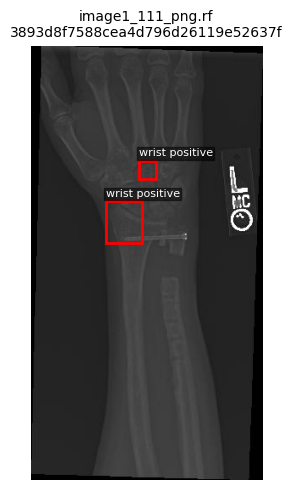

In [60]:
show_sample("valid", "image1_111_png.rf.3893d8f7588cea4d796d26119e52637f")

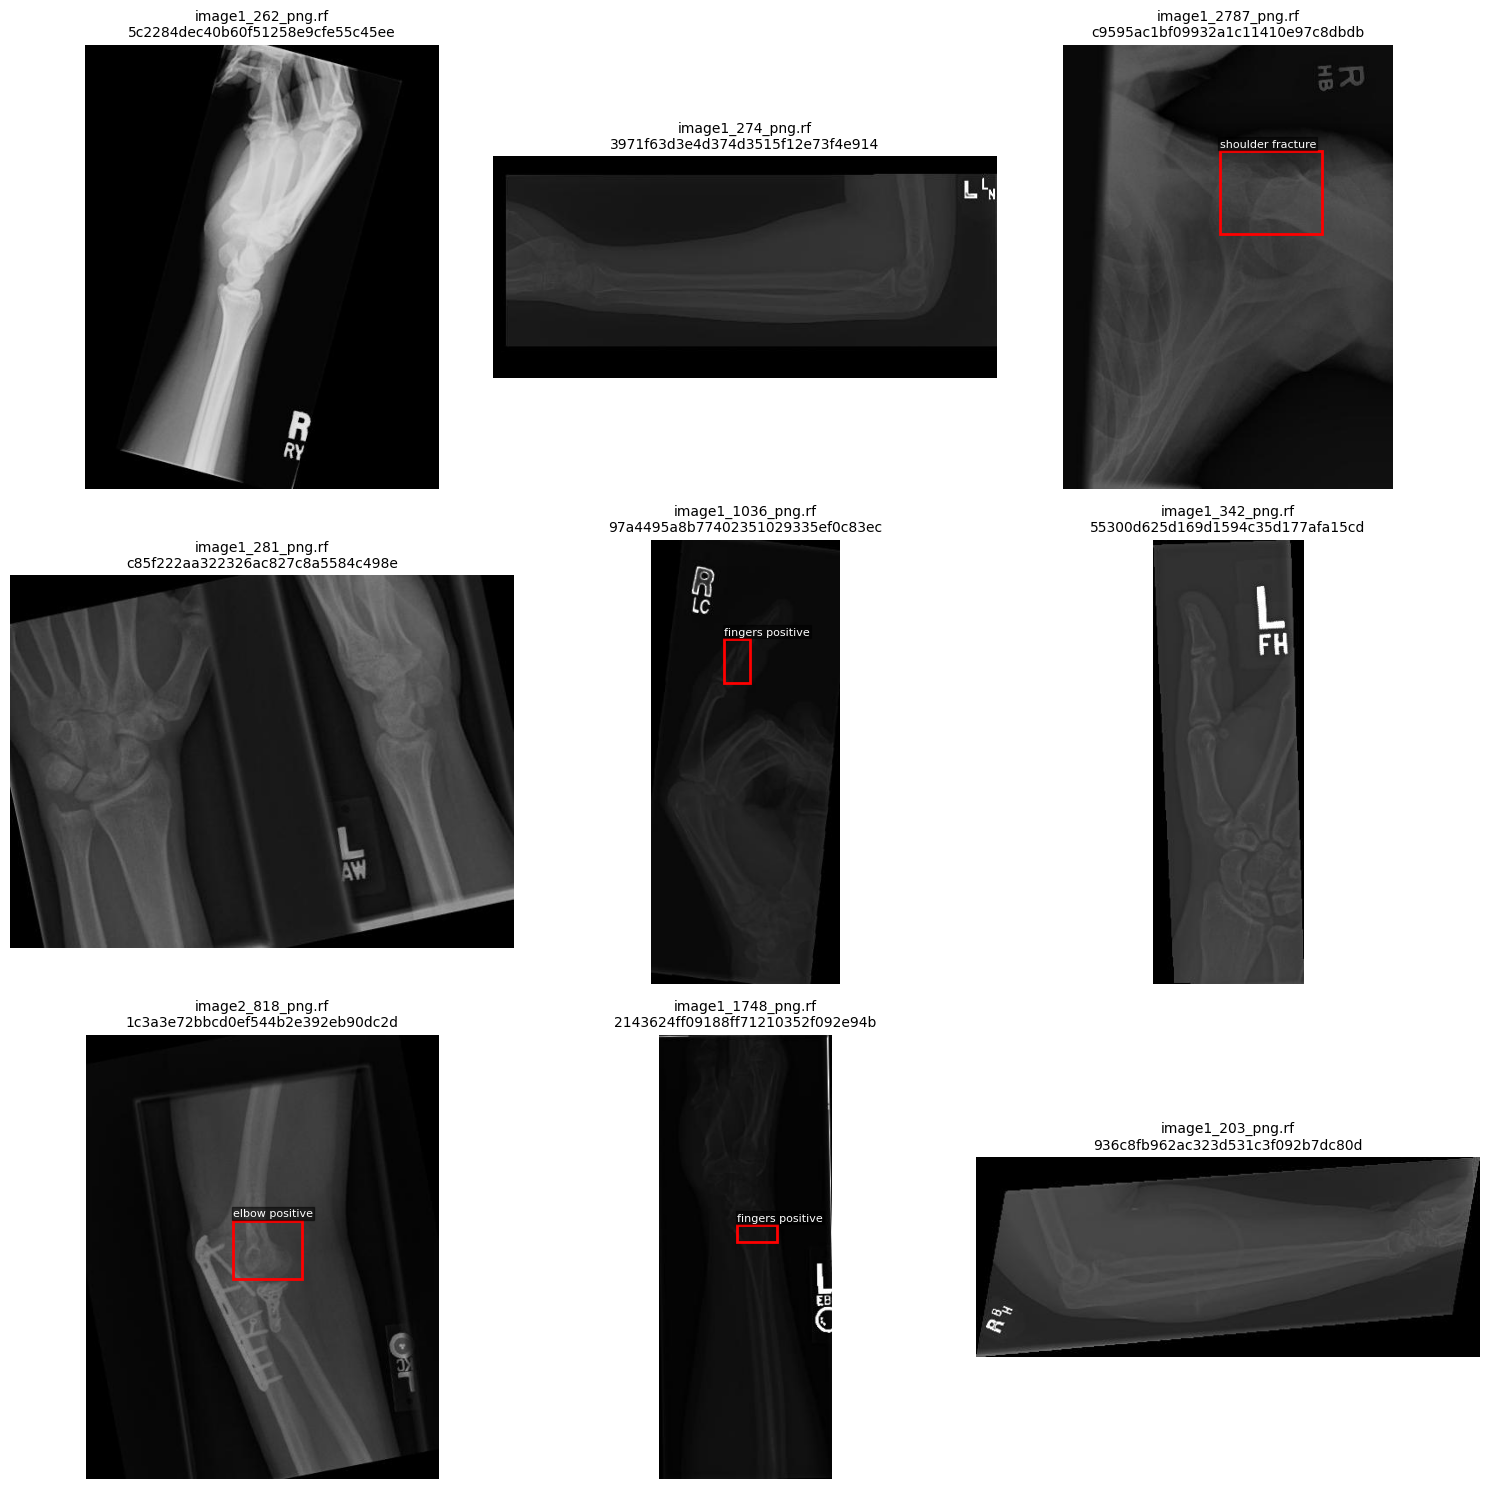

In [61]:
show_samples("train")

## Entrenamiento

In [ ]:
default_config = {
    # Model ---------------------------------------------------------------
    "format": "torchscript",                        # Format to export (torchscript, onnx, etc.)
    #"int8": False,                                  # Use int8 quantization
    "keras": False,                                 # Use Keras export
    "opset": None,                                  # ONNX opset version
    "optimize": False,                              # Optimize model for inference
    "simplify": True,                               # Simplify exported model
    "pretrained": True,                             # Use pretrained weights
    "model": None,                                  # Path to model (.pt or .yaml)
    #"cfg": None,                                    # Path to custom model config

    # Dataset -------------------------------------------------------------
    "data": None,                                   # Dataset config file (.yaml)
    "imgsz": 640,                                   # Input image size (int or [h, w])
    "batch": 16,                                    # Batch size
    "classes": None,                                # Class indices to train on (list)
    "single_cls": False,                            # Train dataset as single-class
    "rect": False,                                  # Use rectangular training
    "augment": True,                                # Apply internal augmentations
    "cache": False,                                 # Cache images for faster training
    "fraction": 1.0,                                # Fraction of dataset to train on
    "nbs": 64,                                      # Nominal batch size

    # Training Schedule ---------------------------------------------------
    "epochs": 100,                                  # Number of epochs
    "time": None,                                   # Max training time (overrides epochs)
    "patience": 50,                                 # Early stopping patience
    "resume": False,                                # Resume from last checkpoint
    "seed": 0,                                      # Random seed
    "deterministic": True,                          # Force deterministic training
    "dropout": 0.0,                                 # Dropout probability
    "mask_ratio": 4,                                # Mask patch ratio (for MAE)
    "overlap_mask": True,                           # Overlapping masks (seg only)
    "retina_masks": False,                          # Retina-style masks (seg only)

    # Optimization --------------------------------------------------------
    "optimizer": "SGD",                             # Optimizer type
    "lr0": 0.01,                                    # Initial learning rate
    "lrf": 0.01,                                    # Final learning rate (lr0 * lrf)
    "momentum": 0.937,                              # Momentum for SGD
    "weight_decay": 0.0005,                         # Weight decay
    "warmup_epochs": 3.0,                           # Warmup epochs
    "warmup_momentum": 0.8,                         # Warmup momentum
    "warmup_bias_lr": 0.1,                          # Warmup bias learning rate
    "cos_lr": False,                                # Cosine LR scheduler
    "amp": True,                                    # Automatic Mixed Precision

    # Augmentation --------------------------------------------------------
    "hsv_h": 0.015,                                 # HSV-Hue
    "hsv_s": 0.7,                                   # HSV-Saturation
    "hsv_v": 0.4,                                   # HSV-Value
    "degrees": 0.0,                                 # Rotation
    "translate": 0.1,                               # Translation
    "scale": 0.5,                                   # Scaling
    "shear": 0.0,                                   # Shearing
    "perspective": 0.0,                             # Perspective transform
    "flipud": 0.0,                                  # Vertical flip
    "fliplr": 0.5,                                  # Horizontal flip

    # Augmentation (continued) --------------------------------------------
    "mosaic": 1.0,                                  # Mosaic augmentation
    "mixup": 0.0,                                   # MixUp
    "copy_paste": 0.0,                              # CopyPaste (seg only)
    "auto_augment": "randaugment",                  # AutoAugment policy
    "copy_paste_mode": "flip",                      # CopyPaste mode
    "erasing": 0.4,                                 # Random erasing
    "close_mosaic": 10,                             # Close mosaic in last N epochs
    "bgr": 0.0,                                     # BGR shift

    # Loss Gains ----------------------------------------------------------
    "box": 7.5,                                     # Box loss gain
    "cls": 0.5,                                     # Classification loss gain
    "dfl": 1.5,                                     # Distribution Focal Loss gain
    "label_smoothing": 0.0,                         # Label smoothing

    # Evaluation & Visualization ------------------------------------------
    "val": True,                                    # Run validation
    "plots": True,                                  # Generate plots
    "show": False,                                  # Show images during training
    "verbose": False,                               # Verbose output
    "visualize": False,                             # Feature visualization
    "show_labels": True,                            # Show labels
    "show_conf": True,                              # Show confidence scores
    "show_boxes": True,                             # Show bounding boxes
    "profile": False,                               # Export profile (speed)

    # Saving & Output -----------------------------------------------------
    "save": True,                                   # Save final model
    "save_period": -1,                              # Save every N epochs
    "project": None,                                # Output root folder
    "name": None,                                   # Run name
    "exist_ok": True,                               # Overwrite output folder
    "save_conf": False,                             # Save confidences
    "save_crop": False,                             # Save cropped detections
    "save_json": False,                             # Save JSON results
    "save_txt": False,                              # Save .txt labels
    "save_frames": False,                           # Save video frames
    "save_dir": None,                               # Output directory

    # Inference -----------------------------------------------------------
    "task": "detect",                               # Task type
    "conf": 0.25,                                   # Confidence threshold
    "iou": 0.7,                                     # IoU threshold
    "max_det": 300,                                 # Max detections per image
    "device": None,                                 # Device to use
    "dynamic": False,                               # Dynamic ONNX shapes
    "half": False,                                  # Use FP16 precision
    "multi_scale": False,                           # Multi-scale training
    "line_width": None,                             # Line width on plots
    "nms": False,                                   # Run NMS postprocessing

    # Extra Inference Options ---------------------------------------------
    "mode": "train",                                # Execution mode
    "source": None,                                 # Input source
    "stream_buffer": False,                         # Stream buffer
    "vid_stride": 1,                                # Video frame stride
    "pose": 12.0,                                   # Keypoints (pose)
    "tracker": "botsort.yaml",                      # Tracker config

    # Miscellaneous -------------------------------------------------------
    "workers": 8,                                   # Number of dataloader workers
    "freeze": None,                                 # Layers to freeze
    "embed": None,                                  # Embedding model
    "agnostic_nms": False                           # Class-agnostic NMS
}


In [ ]:
config = default_config.copy()

train_path = os.path.abspath(f"./train")
filename = datetime.now().strftime("%Y%m%d_%H%M%S")
os.makedirs(os.path.join(train_path, filename), exist_ok=True)

model_path = "yolov8n.pt"

_config = {
    "model": model_path,
    "project": train_path,
    "name": filename,
    "save_dir": os.path.join(train_path, filename),
    "device": "cuda",
    
    "data": os.path.join(data_path, "data.yaml"),
    "imgsz": 512,
    "batch": 8,
    "rect": True,
    "pretrained": True,
    "augment": True,
    
    "epochs": 50,
    #"patience": 30,
    "seed": 42,
    #"dropout": 0.1,
    
    "optimizer": "SGD",
    #"lr0": 0.001,
    #"lrf": 0.01,
    #"cos_lr": True,
    #"amp": True,
    
    #"hsv_h": 0.0,                                 
    #"hsv_s": 0.0,                                   
    #"hsv_v": 0.1,
    #"degrees": 10.0,
    #"translate": 0.1,
    #"scale": 0.3,
    #"flipud": 0.0,
    #"fliplr": 0.5,
    #"mosaic": 0.5,
    "auto_augment": "randaugment",
    #"erasing": 0.1,
    #"mixup": 0.1,
    
    #"box": 7.5,
    #"cls": 0.75,
    #"dfl": 1.5,
    
    #"verbose": True,
    #"save_txt": True,
    
    #"conf": 0.05,
    #"iou": 0.6,
    #"max_det": 5,
    #"nms": False,

    #"deterministic": True,
    #"single_cls": False
}
for key, value in _config.items():
    config[key] = value

with open(os.path.join(train_path, filename, "config.yaml"), "w") as f:
    yaml.safe_dump({**_config}, f)

model = YOLO(model_path)
model.model_name

In [74]:
model = YOLO(model_path)
model.train(**config)

New https://pypi.org/project/ultralytics/8.3.168 available 😃 Update with 'pip install -U ultralytics'
WARNING ⚠️ 'label_smoothing' is deprecated and will be removed in in the future.
Ultralytics 8.3.166 🚀 Python-3.12.7 torch-2.7.1 MPS (Apple M1)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=none, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=0.2, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/Users/jcarmona/Repos/in-progress/KSchool-TFM/data/BoneFractureYolo8/data.yaml, degrees=15.0, deterministic=True, device=mps, dfl=1.5, dnn=False, dropout=0.1, dynamic=False, embed=None, epochs=5, erasing=0.1, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, imgsz=512, int8=False, iou=0.6, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=5, mixup=0.0, mode=train, model=yolov8n.pt, momentum

train: Scanning /Users/jcarmona/Repos/in-progress/KSchool-TFM/data/BoneFractureYolo8/train/labels.cache... 3631 images, 1827 backgrounds, 0 corrupt: 100%|██████████| 3631/3631 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
WARNING ⚠️ 'rect=True' is incompatible with DataLoader shuffle, setting shuffle=False
val: Fast image access ✅ (ping: 0.1±0.1 ms, read: 52.8±29.8 MB/s, size: 12.0 KB)


val: Scanning /Users/jcarmona/Repos/in-progress/KSchool-TFM/data/BoneFractureYolo8/valid/labels.cache... 348 images, 175 backgrounds, 0 corrupt: 100%|██████████| 348/348 [00:00<?, ?it/s]

Plotting labels to /Users/jcarmona/Repos/in-progress/KSchool-TFM/train/20250721_013344/labels.jpg... 


optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 0 dataloader workers
Logging results to /Users/jcarmona/Repos/in-progress/KSchool-TFM/train/20250721_013344
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      2.74G      2.827      6.062      2.296          7        512:  17%|█▋        | 79/454 [06:11<29:25,  4.71s/it]  


KeyboardInterrupt: 